# Autoregressive LSTM 2


In [1]:
import numpy as np
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
#tf.config.list_physical_devices()

2.11.0


## Defining functions for model training

In [2]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    # add extra dimension to 'series' for correct shape
    ds = tf.data.Dataset.from_tensor_slices(series)
    # 1D dataset
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # Shifts window 1 timestep at a time
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # Flattens nested windows into single dataset
    ds = ds.shuffle(shuffle_buffer)
    # Shuffles dataset to ensure training examples are presented in random order
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    # Applies function to each window in dataset
    return ds.batch(batch_size).prefetch(1)

In [3]:
# We can use this function to make some prediction by using the trained model 

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Preprocessing Data

In [4]:
df = pd.read_csv('../../Data/Savitzky-Golay Data/SVG_poly1.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head()

(74783, 2)


,Year,Sunspot_Number
0,1818.001,34.566570
1,1818.004,34.546053
2,1818.007,34.525535
3,1818.010,34.505017
4,1818.012,34.484499


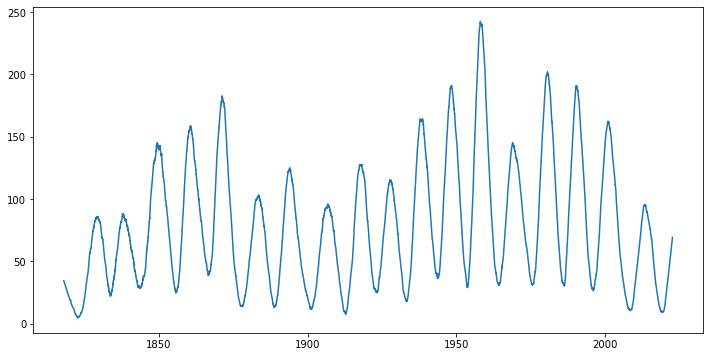

In [5]:
series = df['Sunspot_Number']
time = df['Year']

plt.figure(figsize=(12, 6))
plt.plot(time, series);

In [6]:
split_time = 60000
skips = 20
time_train = time[:split_time:skips]
y_train = series[:split_time:skips]
time_valid = time[split_time::skips]
y_valid = series[split_time::skips]

y_train

0         34.566570
20        34.156216
40        33.745862
60        33.335507
80        32.925153
            ...    
59900    167.683778
59920    165.042437
59940    163.580424
59960    162.341547
59980    161.952772
Name: Sunspot_Number, Length: 3000, dtype: float64

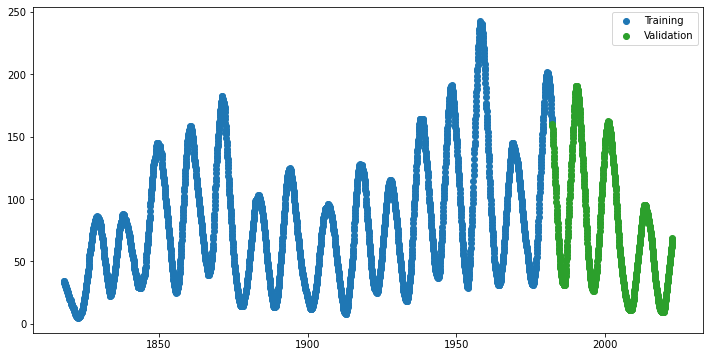

In [7]:
plt.figure(figsize=(12, 6))
plt.scatter(time_train, y_train, color='tab:blue', label='Training')
plt.scatter(time_valid, y_valid, color='tab:green', label='Validation')
plt.legend();

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

shuffle_buffer_size = 1000
window_size = 132
batch_size = 64

# Use windowed_dataset function to make dataset suitable
train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)
print(y_train.shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
(3000,)


## Determining the optimum learning rate

In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                    lambda epoch: 1e-8 * 10**(epoch/20))
# Optimizer and loos parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss = tf.keras.losses.Huber()

In [10]:
# Build and Fit the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
IPython.display.clear_output()
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
45/45 [==============================] - 7s 71ms/step - loss: 89.7125 - mae: 90.2119 - lr: 1.0000e-08
Epoch 2/100
45/45 [==============================] - 3s 55ms/step - loss: 68.7606 - mae: 69.2588 - lr: 1.1220e-08
Epoch 3/100
45/45 [==============================] - 3s 74ms/step - loss: 43.8223 - mae: 44.3182 - lr: 1.2589e-08
Epoch 4/100
45/45 [==============================] - 3s 52ms/step - loss: 33.0657 - mae: 33.5617 - lr: 1.4125e-08
Epoch 5/100
45/45 [==============================] - 3s 55ms/step - loss: 29.6021 - mae: 30.0976 - lr: 1.5849e-08
Epoch 6/100
45/45 [==============================] - 3s 54ms/step - loss: 27.1357 - mae: 27.6297 - lr: 1.7783e-08
Epoch 7/100
45/45 [==============================] - 3s 69ms/step - loss: 24.9798 - mae: 25.4728 - lr: 1.9953e-08
Epoch 8/100
45/45 [==============================] - 3s 58ms/step - loss: 22.9743 - mae: 23.4669 - lr: 2.2387e-08
Epoch 9/100
45/45 [==============================] - 3s 68ms/step - loss: 21.1179 - mae:

(1e-08, 0.001, 0.0, 80.0)

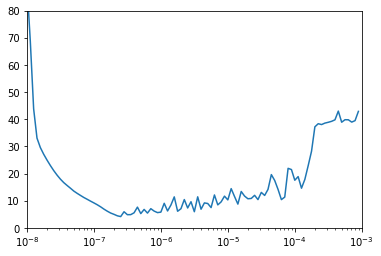

In [11]:
# Let's visualize "learning rate" vs "loss"
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 80])

Optimal learning rate ~ $10^{-6}$

## Training the Model

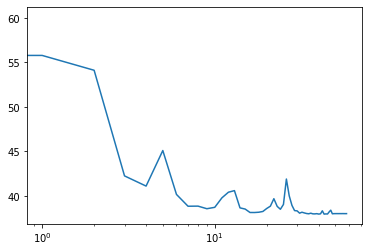

In [12]:
# Let's rerun the model with the optimul learning rate
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

MAX_EPOCHS = 500
patience=15

shuffle_buffer_size = 1000 
window_size = 1000 # How do I choose the optimum size?
batch_size = 64

train_set = windowed_dataset(y_train, window_size, batch_size, shuffle_buffer_size)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss = tf.keras.losses.Huber()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    mode='min')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                          strides=1, padding='causal',
                          activation='relu',
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400) # not sure what is scaling the data
])


model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
history = model.fit(train_set, epochs=MAX_EPOCHS,
                   callbacks=[early_stopping])

IPython.display.clear_output()
plt.semilogx(history.history["loss"]);

In [13]:
def predict_next_values(model, input_series, window_size, num_predictions):
    predictions = []
    input_series = input_series[-window_size:]
    
    for _ in range(num_predictions):
        input_series = np.array(input_series[-window_size:])
        input_series = input_series.reshape((1, window_size, 1))
        prediction = model.predict(input_series)
        predictions.append(prediction[0][0][0])
        input_series = np.append(input_series[0], prediction)
        
    return predictions

In [14]:
num_predictions = len(df) - 65000
next_values = predict_next_values(model, y_train, window_size, num_predictions)
IPython.display.clear_output()

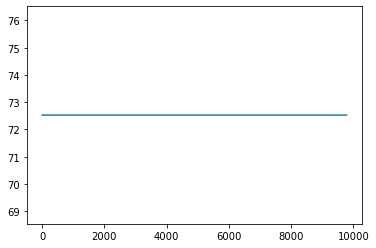

In [15]:
plt.plot(next_values)

ValueError: x and y must have same first dimension, but have shapes (14783,) and (9783,)

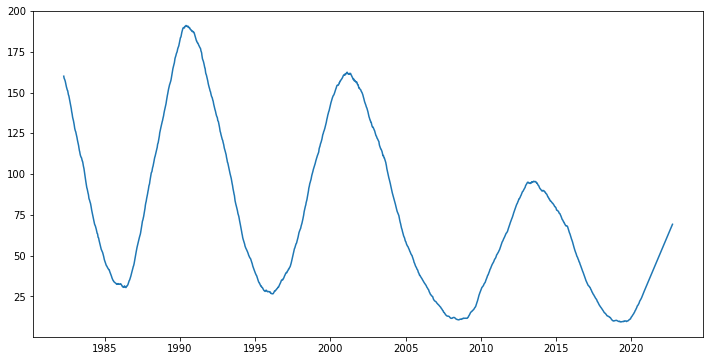

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(time[split_time:], series[split_time:], label='Actual')
plt.plot(time[split_time:], next_values, label='Predicted')
plt.xlabel('Date [Years]')
plt.ylabel('Sunspot Number')
plt.legend();

#### Comment on plot:

This prediction is outstanding... because it has **seen** the data!

In [ ]:
# Standard Deviation 
std_data = np.std(series[split_time:])
std_fc = np.std(rnn_forecast)

normalised_std_data = np.array(std_data / np.mean(series[split_time:]))
normalised_std_fc = np.array(std_fc / np.mean(rnn_forecast))

# Correlation
correlation = np.array(np.corrcoef(series[split_time:], rnn_forecast)[0, 1])

print(f'The normalised standard deviation of the data is {normalised_std_data:.3f}')
print(f'The normalised standard deviation of the forecast is {normalised_std_fc:.3f}, and the correlation is {correlation:.3f}.')